In [1]:
import numpy as np
import torch
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
from model.encoder_perceiver import EncoderPerceiver
from model.encoder_cnn import EncoderResNet
from model.decoder import CaptioningTransformer
from utils.flickr8k_util import FlickrDataset, CapsCollate
from model.utils import show_image, decode_captions, strip_start_end
from experiment.solver import CaptioningSolver

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# load data
transform = T.Compose([
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # for flickr8k
            ])

In [6]:
base_dir = os.getcwd()[:-len("/notebook")]
data_location = base_dir + "/data/Flickr8k"

In [7]:
dataset =  FlickrDataset(
    root_dir = data_location + "/Images",
    caption_file = data_location + "/captions.txt",
    transform = transform,
    verbose = True )

building vocab
buidling caption alias


In [8]:
caption_per_image = 5
num_data = len(dataset)
num_figures = num_data/caption_per_image
test_split = 0.2
val_split = 0.2
train_idx = int((1 - test_split - val_split) * num_figures)
train_abs_idx = train_idx * caption_per_image
val_idx = train_idx + int(val_split * num_figures)
val_abs_idx = val_idx * caption_per_image

In [9]:
train_indices = range(train_abs_idx)
val_indices = range(train_abs_idx, val_abs_idx)
test_indices = range(val_abs_idx, num_data)

In [10]:
# writing the dataloader
# setting the constants
BATCH_SIZE = 32
NUM_WORKER = 2

# token to represent the padding
pad_idx = dataset.vocab.stoi["<NULL>"]

loader_train = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(train_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

loader_val = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(val_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

loader_test = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    sampler = sampler.SubsetRandomSampler(test_indices),
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [11]:
# create models
feature_dim = 512
word_emb_dim = 256

encoder = EncoderResNet(feature_dim)
decoder = CaptioningTransformer(dataset.vocab.stoi, input_dim=feature_dim, 
                                 wordvec_dim = word_emb_dim, max_length=50,
                                 num_heads=2, num_layers=2,)

In [12]:
encoder_optimizer = optim.Adam(encoder.parameters(), 1e-3)
decoder_optimizer = optim.Adam(decoder.parameters(), 2e-3)

In [13]:
solver = CaptioningSolver(encoder, decoder, 
                          encoder_optimizer, decoder_optimizer,
                          dataset.vocab.itos, dataset.caption_alias.caption_alias, 
                          device = device, print_every = 100)

In [14]:
solver.train(loader_train, loader_val, num_epochs=20)

begin training epoch 1 of 20 epochs
training batch 0 of 1 batches
computing BLEU score on training
finish training epoch 1 of 20 epochs
begin validation epoch 1 of 20 epochs
validation batch 0 of 1 batches
computing BLEU score on validation
finish validation epoch 1 of 20 epochs
begin training epoch 2 of 20 epochs


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


training batch 0 of 1 batches
computing BLEU score on training
finish training epoch 2 of 20 epochs
begin validation epoch 2 of 20 epochs
validation batch 0 of 1 batches
computing BLEU score on validation
finish validation epoch 2 of 20 epochs
begin training epoch 3 of 20 epochs
training batch 0 of 1 batches
computing BLEU score on training
finish training epoch 3 of 20 epochs
begin validation epoch 3 of 20 epochs
validation batch 0 of 1 batches
computing BLEU score on validation
finish validation epoch 3 of 20 epochs
begin training epoch 4 of 20 epochs
training batch 0 of 1 batches
computing BLEU score on training
finish training epoch 4 of 20 epochs
begin validation epoch 4 of 20 epochs
validation batch 0 of 1 batches
computing BLEU score on validation
finish validation epoch 4 of 20 epochs
begin training epoch 5 of 20 epochs
training batch 0 of 1 batches
computing BLEU score on training
finish training epoch 5 of 20 epochs
begin validation epoch 5 of 20 epochs
validation batch 0 of 

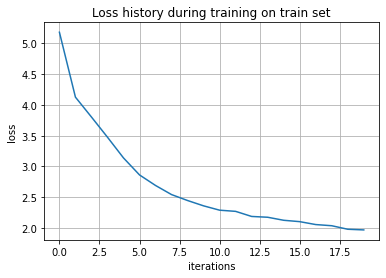

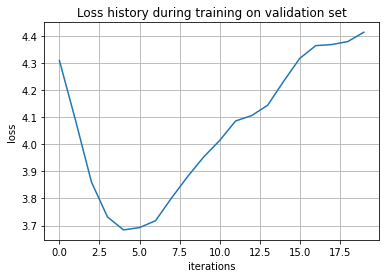

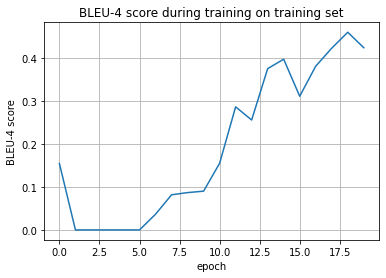

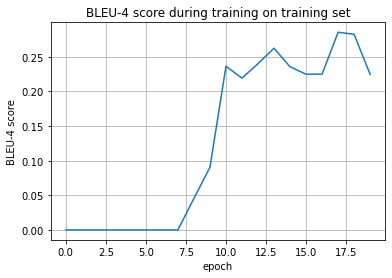

maximum BLEU-4 score on validation:  0.28560956723221126


In [15]:
# visualize training
model_name = "baseline"
plt.plot(solver.train_loss_history)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid()
plt.title("Loss history during training on train set")
plt.savefig(base_dir + "/results/{}_train_loss.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.val_loss_history)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.grid()
plt.title("Loss history during training on validation set")
plt.savefig(base_dir + "/results/{}_val_loss.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.train_bleu)
plt.xlabel("epoch")
plt.ylabel("BLEU-4 score")
plt.grid()
plt.title("BLEU-4 score during training on training set")
plt.savefig(base_dir + "/results/{}_train_BLEU.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

plt.plot(solver.val_bleu)
plt.xlabel("epoch")
plt.ylabel("BLEU-4 score")
plt.grid()
plt.title("BLEU-4 score during training on training set")
plt.savefig(base_dir + "/results/{}_val_BLEU.png".format(model_name), dpi=300, bbox_inches="tight")
plt.show()

print("maximum BLEU-4 score on validation: ", np.max(solver.val_bleu))

In [16]:
# inference

def inference(split_name, loader, filename=None):

    imgs, captions = next(iter(loader_train))
    img = imgs[0] # pick first image from the batch
    caption_vec = captions[0]
    ground_truth = decode_captions(caption_vec.detach().cpu().numpy(), dataset.vocab.itos)
    ground_truth = strip_start_end(ground_truth)
    feature = encoder(img.to(device=device, dtype=torch.float32).reshape(1, 3, 224, 224))
    caption_vec_pred = decoder.sample(feature, max_length=50, device=device)
    predict = decode_captions(caption_vec_pred, dataset.vocab.itos)[0]
    predict = strip_start_end(predict)

    title = "Split:{}\nGT:{}\nPredict:{}".format(split_name, ground_truth, predict)

    inp = img.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis("off")
    plt.title(title)
    plt.savefig(base_dir+"/results/"+filename)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


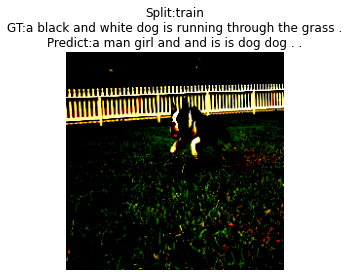

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


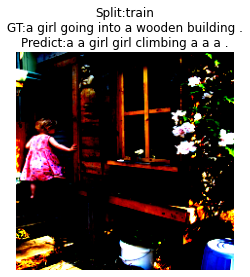

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


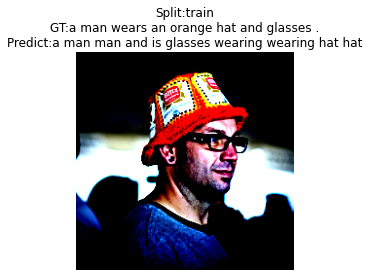

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


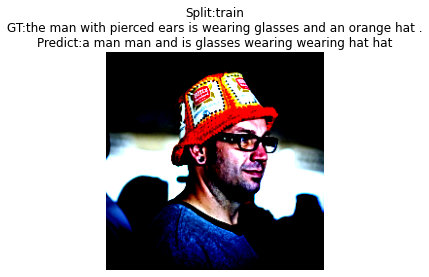

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


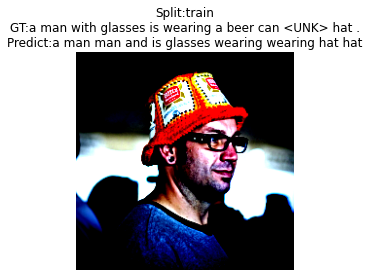

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


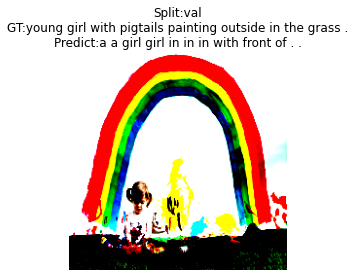

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


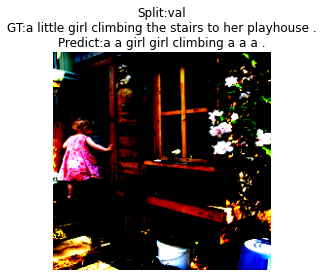

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


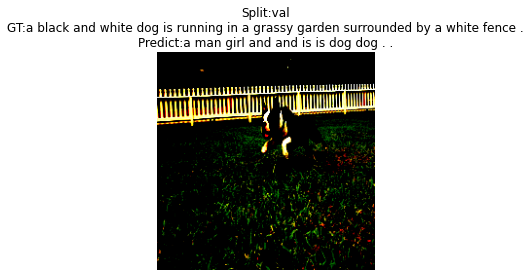

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


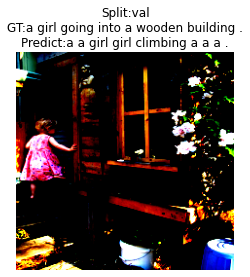

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


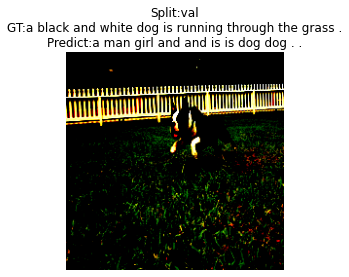

In [19]:
# sample 5 images from train and val
for idx in range(5):
    split_name = "train"
    inference(split_name, loader_train, "inf_{}_{}.png".format(split_name, idx))
    
for idx in range(5):
    split_name = "val"
    inference(split_name, loader_val, "inf_{}_{}.png".format(split_name, idx))

In [25]:
# run on test, only run once!
solver._val_step(loader_test)
bleu_test = solver.val_bleu[-1]
print("BLEU-4 Score on test set: ", bleu_test)

validation batch 0 of 1263 batches


KeyboardInterrupt: 